# Ad-hoc network model 
## Imports

In [19]:
import numpy as np
import pandas as pd 
import ipywidgets as widgets
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


from time import sleep

## Loading data

In [2]:
csv_path = widgets.Text(placeholder="Path to .csv file")
display(csv_path)

Text(value='', placeholder='Path to .csv file')

In [3]:
data = pd.read_csv(csv_path.value)
data.head()

,id,timestamp,x,y,z
0,391682,0,-1665.491089,-1024.396973,13.027639
1,382466,0,-1641.333496,-1046.010132,13.311988
2,321538,0,-1646.880615,-1135.291992,13.017241
3,326914,0,-1674.772217,-1046.162231,13.037983
4,334594,0,-1647.783081,-1125.910034,18.341614


## Preprocessing

The goal here is to filter redundant objects (for example, objects that are currently chilling in the object pool) and split data into small pieces by the timeframe 

In [4]:
filtered_data = data[data.z != -100.0] # Preserve only the objects that are currently somewhere on the map

frames = filtered_data.groupby('timestamp') # Group data into dataframes with equal timestamp, now each group is a snapshot of a moment in time during recording
group_keys = frames.groups.keys() # Now we can iterate over groups

## Model setup

In [5]:
# TODO widget for parameter initialization
# Proposed parameters are: Connectivity distance, something about message generation frequency, ???
connectivity_dist = widgets.BoundedFloatText(
    text = 0.0,
    min = 0.0,
    max = 1000.0,
    step = 1,
    description = "Distance:",
    disabled = False)

display(connectivity_dist)

BoundedFloatText(value=0.0, description='Distance:', max=1000.0, step=1.0)

## Your actor implementation

In [6]:
# TODO Come up with actor interface 
# TODO implement actor. It should be capable of handling high-level shit like sending message to other use and low-level shit like routing messages inside the network
# Are there obvious and correct implementation of the high-level functions that is irrelevant to the protocol of choice? If there is, we should implement them independently of the algo impl (via inheritance)
class Actor:
    def __init__():
        pass

## Model running

In [9]:
# TODO run model, accumulate some statistics
# Proposed stats are: 
# 1. Connection stability (stability metric could be connection lifetime divided over the simulation length) equipped with standard stat tools (mean, stdev, median, possibly distribution, smth else)
# 2. Stats on message delivery efficiency (percentage of successful deliveries, for instance)

# TODO wrap everything up in a function, possibly use something like futures in order to parallelize computations for different datasets, in order to allow for parallel processing of many datasets in order to speed up the whole thing

# Calculate distance between two people
def distance(p1, p2):
    return ((p1.x - p2.x) * (p1.x - p2.x) + (p1.y - p2.y) * (p1.y - p2.y) + (p1.z - p2.z) * (p1.z - p2.z)) ** (1/2)

# Initialize structures for collecting adjacency data
ids = filtered_data['id'].unique() # IDs of users

def first(i, j):
    return min(ids[i], ids[j])

def second(i, j):
    return max(ids[i], ids[j])

# Structure that contains info regarding whether two people were previously connected with one another (Timeframe of connection launch, None otherwise)
connected = dict()

for cur_id in ids:
    connected[cur_id] = dict()

for i in range(len(ids)):
    for j in range(i + 1, len(ids)): # Iterate over the distinct pairs of people
        connected[first(i, j)][second(i, j)] = None # Initialize all pairs as not connected
        
# Structure that contains info about each connection (two connections between the same two people are distinct iff there exists a snapshot where they aren't connected)
# The sequence A <-> B, A <-> B, A <-/-> B, A <-> B contains two connections between A and B
connections = list() 
prev_timestamp = 0

# Nested loops go brrrr (Can we parallelize this piece of shit? Even a little bit?)
for timestamp in tqdm(group_keys): # Iterating over timestamp
    # TODO calculate connections between different people in the current timeframe
    snapshot = frames.get_group(timestamp) # Get a snapshot of a timestamp
    
    current_connectivity = dict()
    for cur_id in ids:
        current_connectivity[cur_id] = dict()
        
    for i in range(len(ids)):
        for j in range(i + 1, len(ids)):
            current_connectivity[first(i, j)][second(i, j)] = False
    
    
    for i in range(snapshot.shape[0]):
        for j in range(i + 1, snapshot.shape[0]): # Iterate over distinct ordered pairs of people 
            p1 = snapshot.iloc[i]
            p2 = snapshot.iloc[j]
            dist = distance(p1, p2)
            if dist < connectivity_dist.value: # If there is connection present
                current_connectivity[min(p1.id, p2.id)][max(p1.id, p2.id)] = True # Mark it is connected

    for i in range(len(ids)):
        for j in range(i + 1, len(ids)):
            a = first(i, j)
            b = second(i, j)
            
            if current_connectivity[a][b]: # If a connection is present 
                if connected[a][b] is None: # And it is a new one
                    connected[a][b] = timestamp # Add it
            elif connected[a][b] is not None: # Otherwise, if the conneciton had just died 
                connections.append({'p1': a, 'p2': b, 'timestamp': connected[a][b], 'lifespan': prev_timestamp - connected[a][b]}) # Record connection stats
                current_connectivity[a][b] = None # Delete connection
    # Now iterate over all the ids in order to figure out the connections that were dropped out 
    
    # TODO check for new/removed connections and update lifetime accordingly
    # TODO run shit like message requests etc and call according functions of the actors
    # Possibly (somehow?) add message throughput limit so that the graph updates would actually influence message routing procedure. Should prolly discuss the best implementation with other project participants.
    prev_timestamp = timestamp
    pass

# Close all the connections that are still present
for i in range(len(ids)):
    for j in range(i + 1, len(ids)):
        a = first(i, j)
        b = second(i, j)
        
        if connected[a][b] is not None:
            connections.append({'p1': a, 'p2': b, 'timestamp': connected[a][b], 'lifespan': prev_timestamp - connected[a][b]}) # Record connection stats
#             print("Added connection info")
            connected[a][b] = None

  0%|          | 0/618 [00:00<?, ?it/s]

#### Statistics

In [15]:
# TODO Show collected stats 
conn_data = pd.DataFrame(connections)


Mean lifespan: 138955.66567189345
lifespan stdev: 75691.58794445814


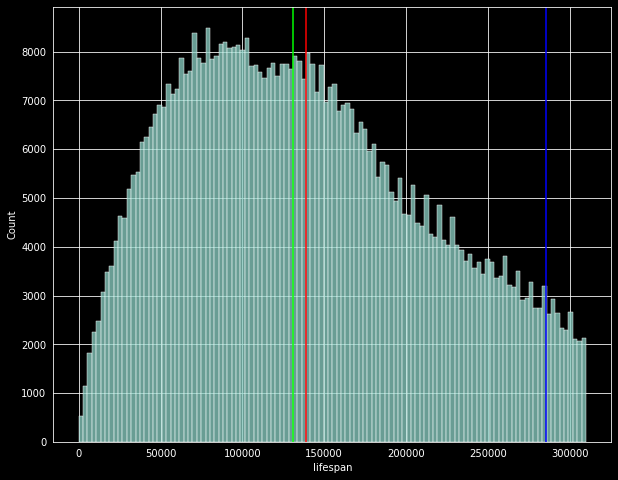

In [49]:
plt.figure(figsize=(10, 8), facecolor=None)
plt.style.use("dark_background")
sns.histplot(conn_data, x="lifespan")

mean_lifespan = conn_data['lifespan'].mean()
median_lifespan = conn_data['lifespan'].median()
stdev_lifespan = conn_data['lifespan'].std()

plt.axvline(mean_lifespan, color="r")
plt.axvline(median_lifespan, color="lime")
plt.axvline(mode_lifespan, color="b")

print("Mean lifespan:", mean_lifespan)
print("lifespan stdev:", stdev_lifespan)

In [45]:
conn_data.mode()

,p1,p2,timestamp,lifespan
0,326914,392706,0,285266


In [53]:
conn_data[conn_data.lifespan == 50000].size

0

In [98]:
conn_data

In [32]:
101012/314800

0.3208767471410419

In [33]:
len(ids)

570

In [13]:
a = list()
a.append(10)

In [14]:
a

[10]